# Visual Data Science | Wrangle & Profile
### Markus Kiesel | 01228952

In [3]:
from datetime import datetime
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.models import GeoJSONDataSource, Patches, LinearColorMapper, ColorBar
from bokeh.palettes import Greens9, Blues9
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

from data import get_merged_data, get_geo_data, DATA_PATH

output_notebook()

Loading BokehJS ...

# Data
The following four data sources are used for this project.

**World Bank Education Database**

This is a collection of 162 education related inicators for 266 countries over the years 1960 to 2020. Most of the indicators are provided separately for female and male which allows a distinction by gender. Further, the metadata includes an income group and region for each country. This is the main source of data used.

**World Bank Harmonized Learning Outcomes (HLO) Database**

This dataset includes an average score across standardized, psychometrically-robust international and regional student achievement tests. To maximize coverage by country, tests have been harmonized and pooled across subjects (math, reading, science) 

**Maddison Project Database 2020**

This dataset is used to add a GDP per capita to our dataset. Several indicators are a rate of GDP.

**Natural Earth**

This data source provides shape-files for our choropleth visualizations.

# Wrangling

First, we have a look at the unprocessed World Bank education data.

The main problem with the dataset is that a lot of missing values are present in the dataset as can be seen in the follwing heatmap.

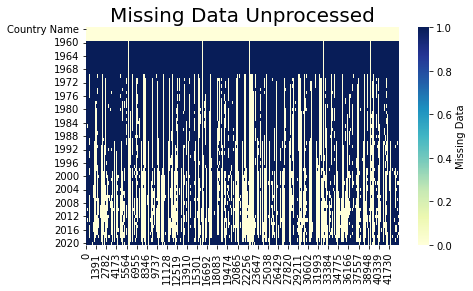

In [31]:
df = pd.read_csv(DATA_PATH / 'world_bank' / 'API_4_DS2_en_csv_v2_3160069.csv', skiprows=4)
df = df.drop(columns=['Unnamed: 65'])
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Missing Data Unprocessed', size=20)
ax.set_xticklabels([])
sns.heatmap(df.isna().T,
            cmap='YlGnBu',
            cbar_kws={'label': 'Missing Data'})
plt.show()

After selecting subsets of indicators from the World Bank Education data which are most useful and have the least missing values we combine the data sources. Then the data is preprocessed furter and we forward fill by country to remove as much missing values as possible.

The heatmap below visualizes the mean number of missing values by indicator and year. We clearly see that almost no data is present before 1970 and the amount of missing data is very high until the year 2000.


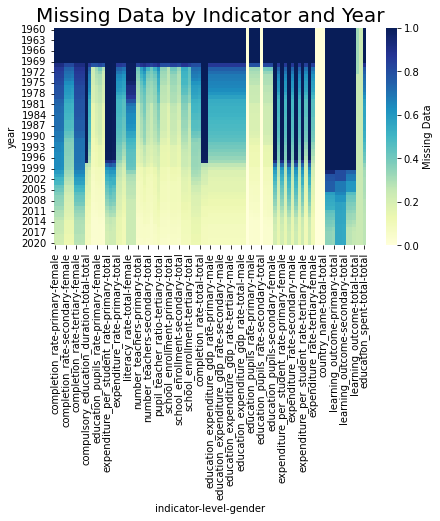

In [32]:
df = get_merged_data(from_year=1960, year_as_datetime=False)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Missing Data by Indicator and Year', size=20)
sns.heatmap(data=df.isna().groupby('year').mean(),
            cmap='YlGnBu',
            cbar_kws={'label': 'Missing Data'})
plt.show()

We use mostly the data from year 2000. In the following heatmap we again see the missing value but with a focus on the country. We clearly notice that some countries have a lot more missing data than others.

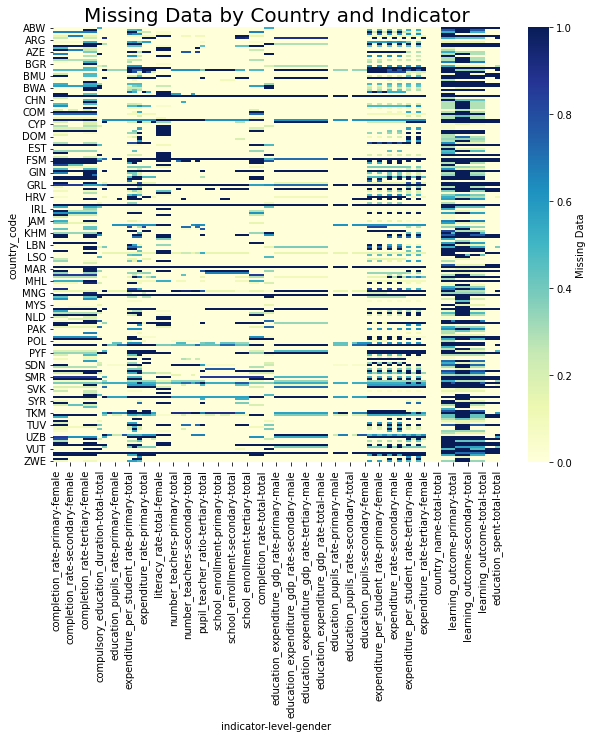

In [12]:
df = get_merged_data(from_year=2000, year_as_datetime=False, indexed=False)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Missing Data by Country and Indicator', size=20)
ax.set_xticklabels([])
sns.heatmap(data=df.isna().groupby('country_code').mean(),
            cmap='YlGnBu',
            cbar_kws={'label': 'Missing Data'})
plt.show()

# Profile

In the next step we have a look at several intersting characteristics of our data.


## Learning Outcome and Education Expenditure 

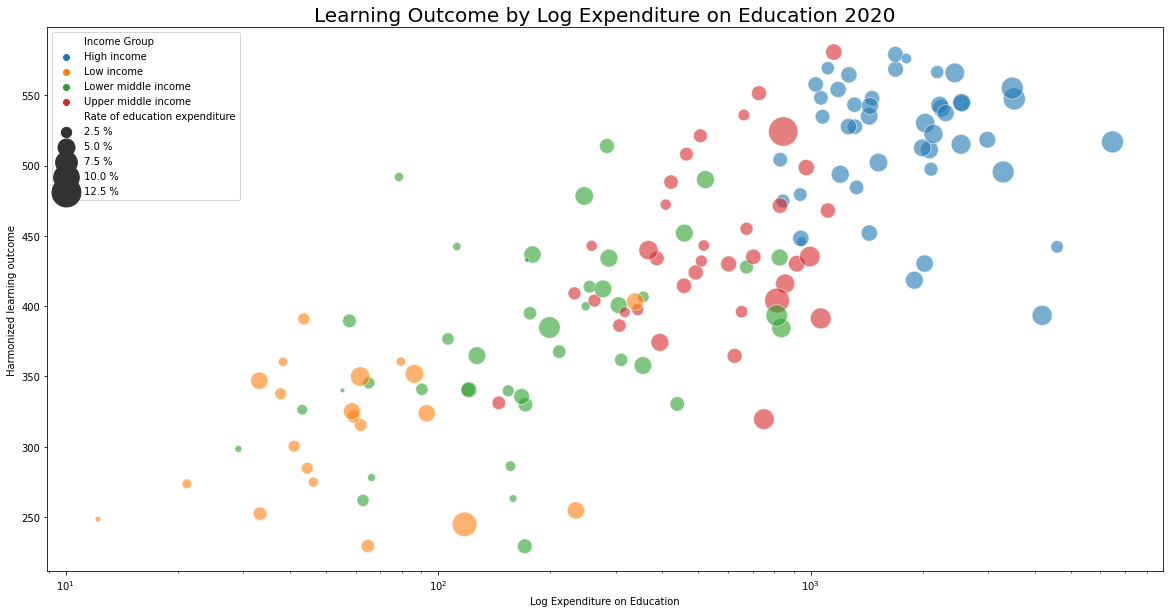

In [16]:
df = get_merged_data(year_as_datetime=False)
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Learning Outcome by Log Expenditure on Education 2020', size=20)
ax.set_xlabel('Log Expenditure on Education')
ax.set_xscale('log')
ax.set_ylabel('Harmonized learning outcome')
sns.scatterplot(
    data=df.xs(2020, level='year').xs(('total', 'total'), axis=1, level=('level', 'gender')),
    x='education_spent',
    y='learning_outcome',
    hue='income_group',
    size='education_expenditure_gdp_rate',
    alpha=0.6,
    sizes=(10, 1000))
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'Income Group'
labels[5] = 'Rate of education expenditure'
labels[6:] = [name + ' %' for name in labels[6:]]
ax.legend(handles, labels)
plt.show()

The above visualization shows the Harmonized Learning Outcome by the the amount of money each country spends on education for the year 2020. (X is log scaled)

We clearly see that the more money is spent on education the higher the Harmonized Learning Outcome.

It is clear that the High Income countries are able to spend more money on education than the lower income countries. The size of the circles represent the rate of GDP each country spends on education.

Is the rate of money spent on education similar or different for each income group?


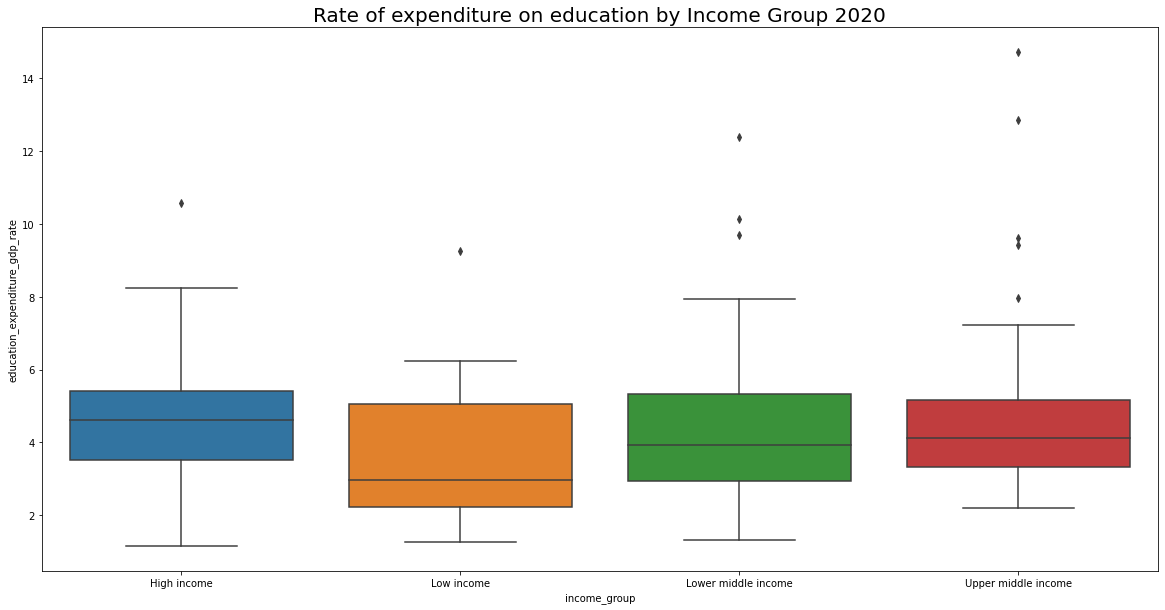

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Rate of expenditure on education by Income Group 2020', size=20)
ax.set_xlabel('Income Group')
ax.set_ylabel('Rate of education expenditure')
sns.boxplot(
    data=df.xs(2020, level='year').xs(('total', 'total'), axis=1, level=('level', 'gender')),
    x='income_group',
    y='education_expenditure_gdp_rate')
plt.show()

The above boxplots show that sadly the lower the income the less the countries spend on education on average.

It is also interesting how different the rate of education expeniture is in each group. While some countries only spend 1 percent on education others spend over 14 percent.


## Education Completion

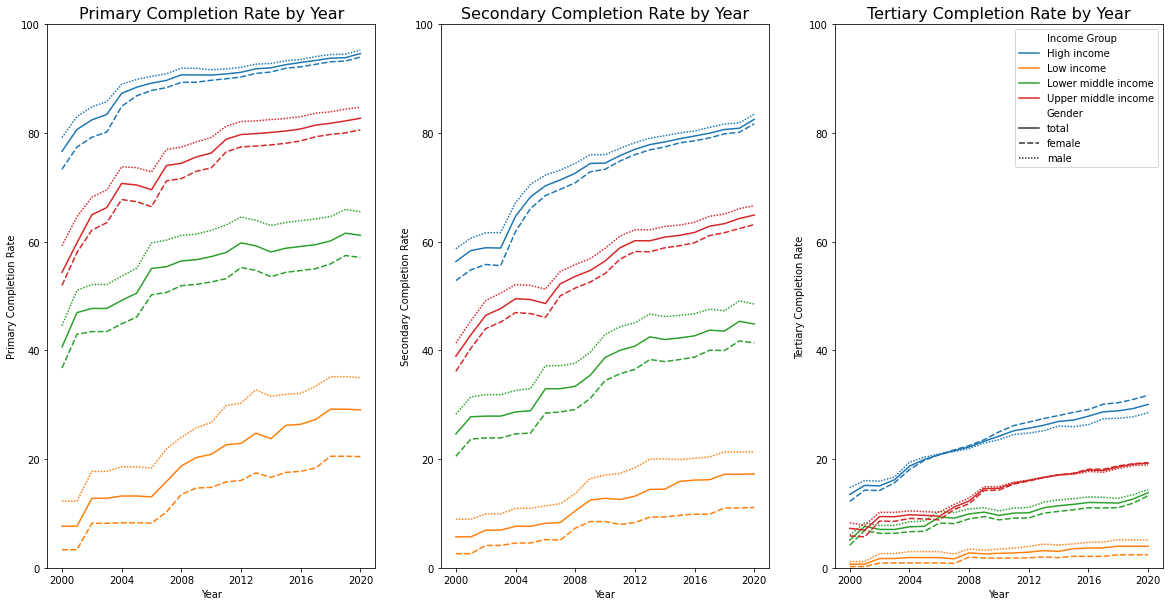

In [15]:
df = get_merged_data(from_year=2000)
df_income_group = pd.DataFrame({'income_group': df[('income_group', 'total', 'total')].copy()})
fig, axs = plt.subplots(figsize=(20, 10), ncols=3)
legend = False
for i, level in enumerate(['primary', 'secondary', 'tertiary']):
    if level == 'tertiary':
        legend='auto'
    sns.lineplot(
        data=df.xs(level, axis=1, level='level').stack().join(df_income_group).groupby(['income_group', 'year', 'gender']).mean().reset_index(),
        x='year',
        y='completion_rate',
        style='gender',
        hue='income_group',
        style_order=['total', 'female', 'male'],
        legend=legend,
        ax=axs[i])
    axs[i].set_title(f'{level.capitalize()} Completion Rate by Year', size=16)
    axs[i].set_ylim((0, 100))
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel(f'{level.capitalize()} Completion Rate')
    if legend:
        handles, labels = axs[i].get_legend_handles_labels()
        labels[0] = 'Income Group'
        labels[5] = 'Gender'
        axs[i].legend(handles, labels)
plt.show()

In the above charts we see the mean Completion Rate for primary, lower-secondary and tertiary Education by each Income Group over the period of 2000 to 2020. Further, the difference for female and male can be seen.

Over the span of 20 years the completion rate increased for all Income Groups, all education levels and both genders. But there is a clear difference between the Income Groups. While the High Income group has a primary school completion rate of almost 100% the Low Income group does not even achieve 30%.

When we have a look at the differences between male and female we notice that the completion rate for male is almost always higher. The higher income countries are more equal and equality shrinks the lower the income. But in High Income countries the women exceed the man in the tertiary completion rate since 2006. 

## Literacy Rate

In [18]:
geo_data = get_geo_data()
df = get_merged_data(from_year=2020, year_as_datetime=False)
df = df.xs(2020, level='year').xs(('total', 'total'), axis=1, level=('level', 'gender'))
geo_data = geo_data.join(df, on='country_code')
geo_source = GeoJSONDataSource(geojson=geo_data.to_json())

choropleth = figure(
    plot_width=900, 
    plot_height=500,
    toolbar_location=None,
    x_axis_location=None,
    y_axis_location=None)
choropleth.grid.visible = False
choropleth.title.text = 'Literacy Rate by Country 2020'
choropleth.title.align = 'center'
choropleth.title.text_font_size = '20px'


color_mapper = LinearColorMapper(
    palette=list(reversed(Greens9)),
    low=0,
    high=100)

patches = Patches(
    xs="xs", ys="ys",
    fill_alpha=0.7, 
    fill_color={'field': 'literacy_rate', 'transform': color_mapper},
    line_color='white', 
    line_width=0.3)
choropleth.add_glyph(geo_source, patches)

color_bar = ColorBar(
    color_mapper=color_mapper,
    location="bottom_left", orientation="horizontal",
    title="Literacy Rate",
    title_text_font_size="14px", title_text_font_style="bold",
    background_fill_alpha=0.0)
choropleth.add_layout(color_bar)

show(choropleth)

The above choropleth shows the literacy rate in 2020 by country. Unfortunately there is a lot of missing data.

We notice that the literacy rate in South America is higher than the rate in most african countries exept for South Africa. Also all European countries have a high literacy rate.

## Learning Outcome

We have one more look at the learning outcome by country.

In [19]:
geo_data = get_geo_data()
df = get_merged_data(from_year=2020, year_as_datetime=False)
df = df.xs(2020, level='year').xs(('total', 'total'), axis=1, level=('level', 'gender'))
geo_data = geo_data.join(df, on='country_code')
geo_source = GeoJSONDataSource(geojson=geo_data.to_json())

choropleth = figure(
    plot_width=900, 
    plot_height=500,
    toolbar_location=None,
    x_axis_location=None,
    y_axis_location=None)
choropleth.grid.visible = False
choropleth.title.text = 'Harmonized Learning Outcome by Country 2020'
choropleth.title.align = 'center'
choropleth.title.text_font_size = '20px'


color_mapper = LinearColorMapper(
    palette=list(reversed(Blues9)),
    low=200,
    high=600)

patches = Patches(
    xs="xs", ys="ys",
    fill_alpha=0.7, 
    fill_color={'field': 'learning_outcome', 'transform': color_mapper},
    line_color='white', 
    line_width=0.3)
choropleth.add_glyph(geo_source, patches)

color_bar = ColorBar(
    color_mapper=color_mapper,
    location="bottom_left", orientation="horizontal",
    title="Learning Outcome",
    title_text_font_size="14px", title_text_font_style="bold",
    background_fill_alpha=0.0)
choropleth.add_layout(color_bar)

show(choropleth)